<a href="https://colab.research.google.com/github/als1379/Statistical-and-Mathematical-Methods-for-Artificial-Intelligence/blob/main/HW4/HW4_MLE_%26_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

csv_large='/content/poly_regression_large.csv'
csv_small='/content/poly_regression_small.csv'

df_large = pd.read_csv(csv_large)
X_large = df_large['x'].values
y_large = df_large['y'].values

_, X_test, _, y_test = train_test_split(
    X_large, y_large, test_size=0.2, random_state=42
)

# Read small dataset (full set used for training)
df_small = pd.read_csv(csv_small)
X_train = df_small['x'].values
y_train = df_small['y'].values

In [4]:
import numpy as np

def polynomial_features(X, K):
    """
    Given a 1D array of inputs X of shape (n,),
    create the design matrix of shape (n, K+1),
    where each row is [1, x, x^2, ..., x^K].
    """
    X = np.array(X)
    # Option A: build manually
    # out = [X**i for i in range(K+1)]
    # return np.column_stack(out)

    # Option B: use np.vander with increasing=True
    return np.vander(X, N=K+1, increasing=True)


In [16]:
def mle_parameters_gd(X, y, K, learning_rate=1e-3, max_iter=200):
    """
    Compute MLE parameters theta via batch Gradient Descent.

    :param X: 1D array of shape (n,)
    :param y: 1D array of shape (n,)
    :param K: Polynomial degree
    :param learning_rate: Step size for gradient updates
    :param max_iter: Maximum number of iterations
    :return: theta of shape (K+1,)
    """

    # Build the design matrix
    Phi = polynomial_features(X, K)  # shape (n, K+1)
    n = Phi.shape[0]

    # Initialize theta
    theta = np.zeros(K+1)

    for _ in range(max_iter):
        # Compute predictions: Phi * theta
        y_pred = Phi @ theta  # shape (n,)

        # Compute gradient of MSE w.r.t. theta
        # gradient = (1/n) * Phi.T * (Phi * theta - y)
        gradient = (1.0 / n) * (Phi.T @ (y_pred - y))

        # Update theta
        theta -= learning_rate * gradient

    return theta


In [6]:
def mle_parameters_sgd(X, y, K, learning_rate=1e-3, max_iter=200, batch_size=5):
    """
    Compute MLE parameters theta via Stochastic Gradient Descent
    (mini-batch of size 5).

    :param X: 1D array of shape (n,)
    :param y: 1D array of shape (n,)
    :param K: Polynomial degree
    :param learning_rate: Step size for gradient updates
    :param max_iter: Number of epochs (passes over the entire dataset)
    :param batch_size: Size of each mini-batch
    :return: theta of shape (K+1,)
    """

    Phi = polynomial_features(X, K)
    n = Phi.shape[0]
    theta = np.zeros(K+1)

    # Number of batches per epoch
    num_batches = n // batch_size
    if n % batch_size != 0:
        num_batches += 1  # account for the last partial batch if n is not multiple of batch_size

    for epoch in range(max_iter):
        # Shuffle data each epoch for better SGD
        indices = np.arange(n)
        np.random.shuffle(indices)

        # Go through mini-batches
        for i in range(num_batches):
            # Batch indices
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            batch_indices = indices[start_idx:end_idx]

            Phi_batch = Phi[batch_indices]  # shape (batch_size, K+1)
            y_batch = y[batch_indices]      # shape (batch_size,)

            # Forward pass for this batch
            y_pred = Phi_batch @ theta

            # Gradient on this batch
            # gradient = (1/|batch|) * Phi_batch.T * (Phi_batch * theta - y_batch)
            gradient = (1.0 / len(y_batch)) * (Phi_batch.T @ (y_pred - y_batch))

            # Update
            theta -= learning_rate * gradient

    return theta


In [7]:
def mle_parameters_normal_eq(X, y, K):
    """
    Compute MLE parameters theta via the Normal Equations
    and solve using Cholesky decomposition.

    :param X: 1D array of shape (n,)
    :param y: 1D array of shape (n,)
    :param K: Polynomial degree
    :return: theta of shape (K+1,)
    """
    Phi = polynomial_features(X, K)

    # A = Phi^T * Phi
    A = Phi.T @ Phi  # shape (K+1, K+1)
    b = Phi.T @ y    # shape (K+1,)

    # Cholesky factorization of A
    # A must be positive definite for Cholesky to work (which it is if Phi has full column rank).
    L = np.linalg.cholesky(A)  # L is lower-triangular, shape (K+1, K+1)

    # Solve L z = b
    z = np.linalg.solve(L, b)

    # Solve L^T theta = z
    theta = np.linalg.solve(L.T, z)

    return theta


In [17]:
# Choose polynomial degree
K = 3

# 1) Gradient Descent
theta_gd = mle_parameters_gd(X_train, y_train, K, learning_rate=1e-3, max_iter=200)

# 2) Stochastic Gradient Descent (batch_size=5)
theta_sgd = mle_parameters_sgd(X_train, y_train, K, learning_rate=1e-3, max_iter=200, batch_size=5)

# 3) Normal Equations + Cholesky
theta_ne = mle_parameters_normal_eq(X_train, y_train, K)

print("Gradient Descent   :", theta_gd)
print("SGD (batch_size=5) :", theta_sgd)
print("Normal Equations   :", theta_ne)


Gradient Descent   : [0.12347922 0.08711538 0.06541752 0.05160888]
SGD (batch_size=5) : [0.39152772 0.36821654 0.28484216 0.22109886]
Normal Equations   : [ 0.07903542 -1.47472763  9.51845896 -7.14903107]


In [18]:
import numpy as np

def mean_squared_error(X_test, y_test, theta, K):
    """
    Computes the MSE for a given theta on the test set.

    :param X_test: 1D array of shape (N_test,)
    :param y_test: 1D array of shape (N_test,)
    :param theta: Fitted parameter vector of shape (K+1,)
    :param K: Polynomial degree
    :return: The MSE (a scalar).
    """
    # Create polynomial design matrix for X_test
    Phi_test = polynomial_features(X_test, K)  # shape (N_test, K+1)

    # Compute predictions
    y_pred = Phi_test @ theta  # shape (N_test,)

    # Mean squared error
    mse = np.mean((y_pred - y_test)**2)
    return mse


In [19]:

# Compute test MSE
mse_gd = mean_squared_error(X_test, y_test, theta_gd, K)
mse_sgd = mean_squared_error(X_test, y_test, theta_sgd, K)
mse_ne = mean_squared_error(X_test, y_test, theta_ne, K)

print("Test MSE (Gradient Descent)   =", mse_gd)
print("Test MSE (SGD, batch_size=5)  =", mse_sgd)
print("Test MSE (Normal Equations)   =", mse_ne)


Test MSE (Gradient Descent)   = 0.4788567618778696
Test MSE (SGD, batch_size=5)  = 0.08656262663100239
Test MSE (Normal Equations)   = 0.009748732757437649


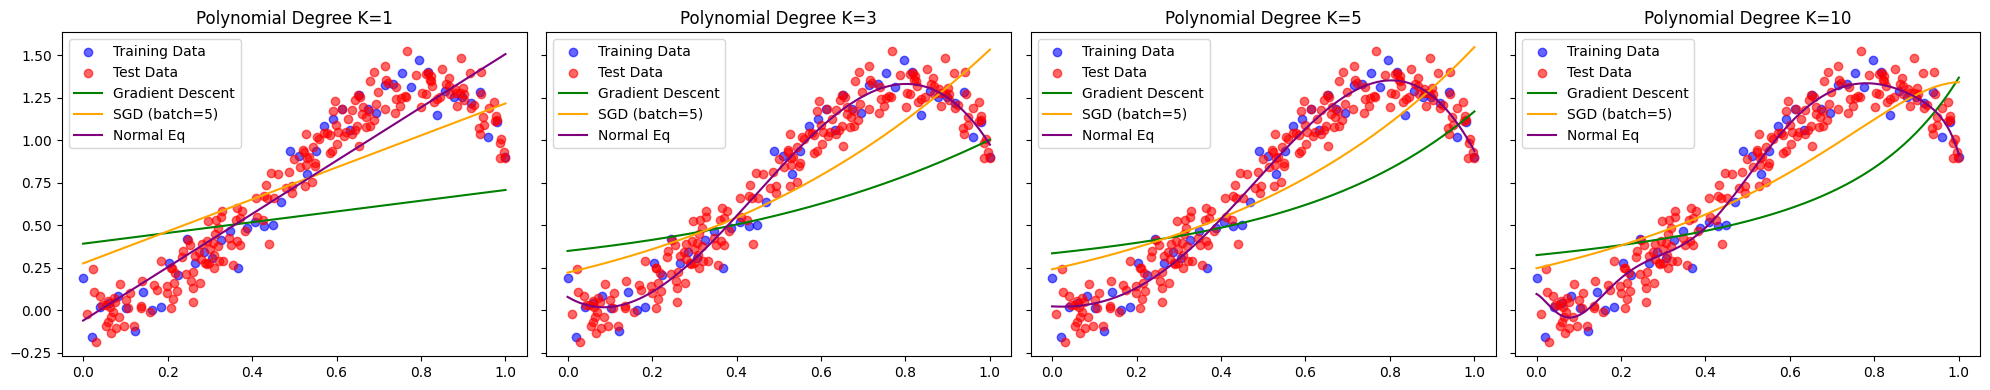

In [25]:
import matplotlib.pyplot as plt

def plot_models_for_degrees(degrees, X_train, y_train, X_test, y_test,
                            gd_params=None, sgd_params=None):
    """
    Plot the training and test data for each K in `degrees`,
    along with the polynomial regression fits from:
       1) Gradient Descent
       2) SGD
       3) Normal Equations

    gd_params: dict of {'learning_rate': float, 'max_iter': int}
    sgd_params: dict of {'learning_rate': float, 'max_iter': int, 'batch_size': int}
    """
    if gd_params is None:
        gd_params = {'learning_rate': 1e-3, 'max_iter': 1000}
    if sgd_params is None:
        sgd_params = {'learning_rate': 1e-3, 'max_iter': 1000, 'batch_size': 5}

    # Create figure
    num_degrees = len(degrees)
    fig, axes = plt.subplots(1, num_degrees, figsize=(5*num_degrees, 4),
                             sharey=True)
    if num_degrees == 1:
        axes = [axes]  # Make it a list for consistency in looping

    # Limits for plotting lines
    x_min = min(np.min(X_train), np.min(X_test))
    x_max = max(np.max(X_train), np.max(X_test))

    # Create a dense grid of x-values for plotting the fitted curves
    x_plot = np.linspace(x_min, x_max, 200)
    gd_train_errors = []
    gd_test_errors = []
    sgd_train_errors = []
    sgd_test_errors = []
    ne_train_errors = []
    ne_test_errors = []
    for i, K in enumerate(degrees):
        ax = axes[i]

        # -- 1) Fit with Gradient Descent
        theta_gd = mle_parameters_gd(X_train, y_train, K,
                                     learning_rate=gd_params['learning_rate'],
                                     max_iter=gd_params['max_iter'])

        # -- 2) Fit with SGD
        theta_sgd = mle_parameters_sgd(X_train, y_train, K,
                                       learning_rate=sgd_params['learning_rate'],
                                       max_iter=sgd_params['max_iter'],
                                       batch_size=sgd_params['batch_size'])

        # -- 3) Fit with Normal Equations
        theta_ne = mle_parameters_normal_eq(X_train, y_train, K)

        # Build polynomial design matrix for plotting
        Phi_plot = polynomial_features(x_plot, K)

        # Compute predictions
        y_plot_gd = Phi_plot @ theta_gd
        y_plot_sgd = Phi_plot @ theta_sgd
        y_plot_ne = Phi_plot @ theta_ne

        mse_train_gd = mean_squared_error(X_train, y_train, theta_gd, K)
        mse_test_gd = mean_squared_error(X_test, y_test, theta_gd, K)
        gd_train_errors.append(mse_train_gd)
        gd_test_errors.append(mse_test_gd)

        mse_train_sgd = mean_squared_error(X_train, y_train, theta_sgd, K)
        mse_test_sgd = mean_squared_error(X_test, y_test, theta_sgd, K)
        sgd_train_errors.append(mse_train_sgd)
        sgd_test_errors.append(mse_test_sgd)

        mse_train_ne = mean_squared_error(X_train, y_train, theta_ne, K)
        mse_test_ne = mean_squared_error(X_test, y_test, theta_ne, K)
        ne_train_errors.append(mse_train_ne)
        ne_test_errors.append(mse_test_ne)

        # Plot the training data
        ax.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.6)
        # Plot the test data
        ax.scatter(X_test, y_test, color='red', label='Test Data', alpha=0.6)

        # Plot the fitted lines
        ax.plot(x_plot, y_plot_gd, color='green', label='Gradient Descent')
        ax.plot(x_plot, y_plot_sgd, color='orange', label='SGD (batch=5)')
        ax.plot(x_plot, y_plot_ne, color='purple', label='Normal Eq')

        ax.set_title(f'Polynomial Degree K={K}')
        ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

    return gd_train_errors, gd_test_errors, sgd_train_errors, sgd_test_errors, ne_train_errors, ne_test_errors

# Example usage:
degrees_to_try = [1, 3, 5, 10]
gd_train_errors, gd_test_errors, sgd_train_errors, sgd_test_errors, ne_train_errors, ne_test_errors = plot_models_for_degrees(degrees_to_try, X_train, y_train, X_test, y_test)


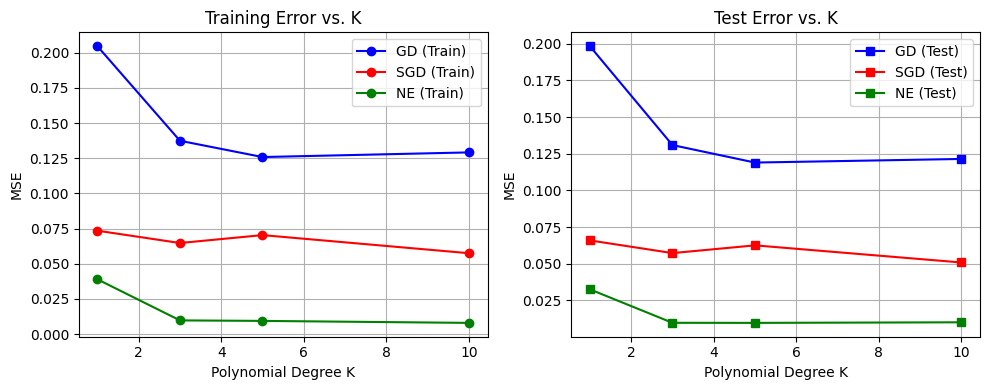

In [26]:
import matplotlib.pyplot as plt

# Suppose you have:
# degrees            = list or array of polynomial degrees
# gd_train_errors    = [mse_train_gd_K0, mse_train_gd_K1, ..., mse_train_gd_Kmax]
# gd_test_errors     = [mse_test_gd_K0,  mse_test_gd_K1,  ..., mse_test_gd_Kmax]
# sgd_train_errors   = ...
# sgd_test_errors    = ...
# ne_train_errors    = ...
# ne_test_errors     = ...

plt.figure(figsize=(10, 4))

# -- Subplot for Training Error
plt.subplot(1, 2, 1)
plt.plot(degrees_to_try, gd_train_errors, marker='o', label='GD (Train)', color='blue')
plt.plot(degrees_to_try, sgd_train_errors, marker='o', label='SGD (Train)', color='red')
plt.plot(degrees_to_try, ne_train_errors, marker='o', label='NE (Train)', color='green')
plt.xlabel('Polynomial Degree K')
plt.ylabel('MSE')
plt.title('Training Error vs. K')
plt.legend()
plt.grid(True)

# -- Subplot for Test Error
plt.subplot(1, 2, 2)
plt.plot(degrees_to_try, gd_test_errors, marker='s', label='GD (Test)', color='blue')
plt.plot(degrees_to_try, sgd_test_errors, marker='s', label='SGD (Test)', color='red')
plt.plot(degrees_to_try, ne_test_errors, marker='s', label='NE (Test)', color='green')
plt.xlabel('Polynomial Degree K')
plt.ylabel('MSE')
plt.title('Test Error vs. K')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
def map_parameters_gd(X, y, K, lam=1e-2, learning_rate=1e-3, max_iter=1000):
    """
    Compute MAP parameters (ridge) via Gradient Descent.

    :param X: 1D array (n, )
    :param y: 1D array (n, )
    :param K: Polynomial degree
    :param lam: Ridge regularization parameter (lambda)
    :param learning_rate: Step size
    :param max_iter: Number of iterations
    :return: theta (K+1, )
    """
    Phi = polynomial_features(X, K)  # shape (n, K+1)
    n = Phi.shape[0]

    # Initialize theta
    theta = np.zeros(K+1)

    for _ in range(max_iter):
        # Predictions
        y_pred = Phi @ theta

        # Gradient
        # grad = (1/n)*Phi.T*(Phi*theta - y) + lam*theta
        grad = (1.0 / n) * (Phi.T @ (y_pred - y)) + lam * theta

        # Parameter update
        theta -= learning_rate * grad

    return theta


def map_parameters_sgd(X, y, K, lam=1e-2, learning_rate=1e-3,
                       max_iter=200, batch_size=5):
    """
    Compute MAP parameters (ridge) via Stochastic Gradient Descent (mini-batch).

    :param X: 1D array of shape (n,)
    :param y: 1D array of shape (n,)
    :param K: Polynomial degree
    :param lam: Ridge regularization parameter (lambda)
    :param learning_rate: Step size for SGD
    :param max_iter: Number of epochs
    :param batch_size: Size of each mini-batch
    :return: theta of shape (K+1,)
    """
    Phi = polynomial_features(X, K)
    n = Phi.shape[0]
    theta = np.zeros(K+1)

    num_batches = n // batch_size
    if n % batch_size != 0:
        num_batches += 1  # last partial batch if needed

    for epoch in range(max_iter):
        # Shuffle the data each epoch
        indices = np.arange(n)
        np.random.shuffle(indices)

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            batch_indices = indices[start_idx:end_idx]

            Phi_batch = Phi[batch_indices]
            y_batch = y[batch_indices]

            y_pred = Phi_batch @ theta

            # gradient wrt theta:
            #  (1/|batch|) * Phi_batch^T (Phi_batch theta - y_batch) + lam * theta
            grad = (1.0 / len(batch_indices)) * (Phi_batch.T @ (y_pred - y_batch)) + lam * theta

            # update theta
            theta -= learning_rate * grad

    return theta


def map_parameters_normal_ne_cholesky(X, y, K, lam=1e-2):
    """
    Compute MAP (ridge) parameters via the Normal Equations
    using Cholesky decomposition:
       theta = (Phi^T Phi + lam * I)^{-1} Phi^T y
    but we do not explicitly invert; we do Cholesky factorization and solve.

    :param X: 1D array (n,)
    :param y: 1D array (n,)
    :param K: Polynomial degree
    :param lam: Ridge regularization parameter
    :return: theta of shape (K+1,)
    """
    Phi = polynomial_features(X, K)           # shape (n, K+1)
    A = Phi.T @ Phi                           # shape (K+1, K+1)

    # Add lambda * I to A
    n_params = A.shape[0]
    A += lam * np.eye(n_params)

    # Vector b
    b = Phi.T @ y                             # shape (K+1,)

    # Cholesky factorization: A = L * L^T
    L = np.linalg.cholesky(A)                 # shape (K+1, K+1), lower triangular

    # Solve L z = b  -> z
    z = np.linalg.solve(L, b)                 # shape (K+1,)

    # Solve L^T theta = z  -> theta
    theta = np.linalg.solve(L.T, z)           # shape (K+1,)

    return theta


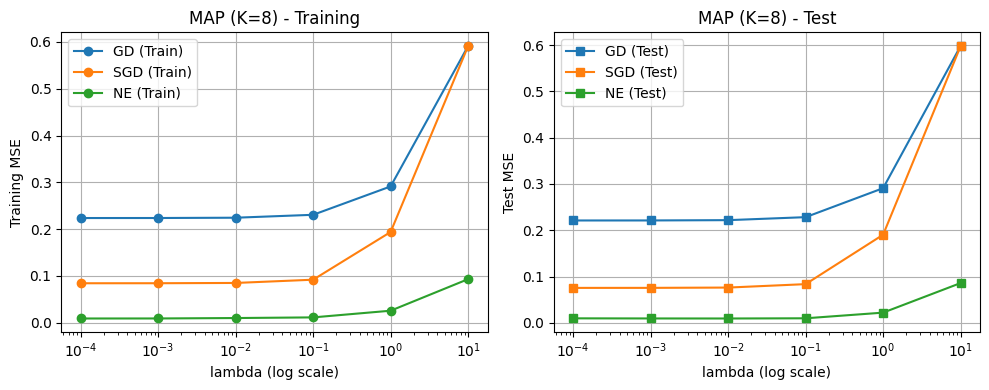

In [32]:
def run_map_experiments(X_train, y_train, X_test, y_test,
                        degree=8,
                        lambdas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
                        gd_params=None,
                        sgd_params=None):
    """
    For each lambda in `lambdas`, compute MAP estimates using:
      1) Gradient Descent
      2) SGD
      3) Normal Equations (Cholesky)
    Then record train/test MSE for each method.
    """
    if gd_params is None:
        gd_params = {'learning_rate': 1e-3, 'max_iter': 5000}
    if sgd_params is None:
        sgd_params = {'learning_rate': 1e-3, 'max_iter': 500, 'batch_size': 5}

    # Store results in dict-of-lists
    gd_train_errors = []
    gd_test_errors  = []

    sgd_train_errors = []
    sgd_test_errors  = []

    ne_train_errors = []
    ne_test_errors  = []

    for lam in lambdas:
        # --- MAP by Gradient Descent
        theta_gd = map_parameters_gd(
            X_train, y_train, degree, lam=lam,
            learning_rate=gd_params['learning_rate'],
            max_iter=gd_params['max_iter']
        )
        mse_train_gd = mean_squared_error(X_train, y_train, theta_gd, degree)
        mse_test_gd  = mean_squared_error(X_test,  y_test,  theta_gd, degree)
        gd_train_errors.append(mse_train_gd)
        gd_test_errors.append(mse_test_gd)

        # --- MAP by SGD
        theta_sgd = map_parameters_sgd(
            X_train, y_train, degree, lam=lam,
            learning_rate=sgd_params['learning_rate'],
            max_iter=sgd_params['max_iter'],
            batch_size=sgd_params['batch_size']
        )
        mse_train_sgd = mean_squared_error(X_train, y_train, theta_sgd, degree)
        mse_test_sgd  = mean_squared_error(X_test,  y_test,  theta_sgd, degree)
        sgd_train_errors.append(mse_train_sgd)
        sgd_test_errors.append(mse_test_sgd)

        # --- MAP by Normal Equations (Cholesky)
        theta_ne = map_parameters_normal_ne_cholesky(X_train, y_train, degree, lam=lam)
        mse_train_ne = mean_squared_error(X_train, y_train, theta_ne, degree)
        mse_test_ne  = mean_squared_error(X_test,  y_test,  theta_ne, degree)
        ne_train_errors.append(mse_train_ne)
        ne_test_errors.append(mse_test_ne)

    # --- Plot the train/test MSE vs lambda
    plt.figure(figsize=(10, 4))

    # Subplot for Training Error
    plt.subplot(1, 2, 1)
    plt.plot(lambdas, gd_train_errors, marker='o', label='GD (Train)')
    plt.plot(lambdas, sgd_train_errors, marker='o', label='SGD (Train)')
    plt.plot(lambdas, ne_train_errors, marker='o', label='NE (Train)')
    plt.xscale('log')  # often helpful to use log-scale for lambda
    plt.xlabel('lambda (log scale)')
    plt.ylabel('Training MSE')
    plt.title(f'MAP (K={degree}) - Training')
    plt.legend()
    plt.grid(True)

    # Subplot for Test Error
    plt.subplot(1, 2, 2)
    plt.plot(lambdas, gd_test_errors, marker='s', label='GD (Test)')
    plt.plot(lambdas, sgd_test_errors, marker='s', label='SGD (Test)')
    plt.plot(lambdas, ne_test_errors, marker='s', label='NE (Test)')
    plt.xscale('log')
    plt.xlabel('lambda (log scale)')
    plt.ylabel('Test MSE')
    plt.title(f'MAP (K={degree}) - Test')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # (Optionally) return results if needed
    return {
        'lambdas': lambdas,
        'gd_train': gd_train_errors,
        'gd_test': gd_test_errors,
        'sgd_train': sgd_train_errors,
        'sgd_test': sgd_test_errors,
        'ne_train': ne_train_errors,
        'ne_test': ne_test_errors
    }

K=8
# Example usage:
results = run_map_experiments(X_train, y_train, X_test, y_test,
                              degree=K,
                              lambdas=[1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
                              gd_params={'learning_rate': 1e-3, 'max_iter': 500},
                              sgd_params={'learning_rate': 1e-3, 'max_iter': 500, 'batch_size': 5})


 We cannot see overfitting in mle and map because not much difference of training and test errors.

 so we cannot see improvement in test mse by using map

 however by incrasing lambda too much we broke the model
